In [1]:
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn import metrics
import time
from datetime import datetime, timedelta
from sklearn import svm
import pandas as pd
import matplotlib.pyplot as plt
import math
from sklearn import preprocessing
from math import sqrt
import seaborn as sns; sns.set()
import ast
from technicalSignals import momentum,SMA,inBBands


In [2]:
# ========== GOOGLE SENTIMENT vs DICTIONARY  =================
#
# EXPERIMENT WITH TIMESTEP 1H
#
# Predict if the volume is higher respect to 
#

newsGoogle =  pd.read_csv('/home/simone/Desktop/NLFF/GoogleNL/Aggregated_1h_dataset/AAPL_googleSentPerTimestep.csv')
newsDict =  pd.read_csv('/home/simone/Desktop/NLFF/intrinioDatasetUpdated/SentimentFullAggregatedHourly/AAPL.csv')

price = pd.read_csv('/home/simone/Desktop/NLFF/indexes/indexesAAPL.csv')

price = price.rename(index=str, columns={"date": "DATE"})
newsGoogle = newsGoogle.rename(index=str, columns={"initTime": "DATE"})
newsDict = newsDict.rename(index=str, columns={"initTime": "DATE"})
newsGoogle = newsGoogle.drop(['Unnamed: 0'], axis=1)



newsGoogle['DATE'] = [datetime.strptime(row, '%Y-%m-%d %H:%M:%S') for row in newsGoogle['DATE']]
newsDict['DATE'] = [datetime.strptime(row, '%Y-%m-%d %H:%M:%S') for row in newsDict['DATE']]


# This datased is already GMT+0
price['DATE'] = [datetime.strptime(row, '%Y-%m-%d %H:%M:%S') for row in price['DATE']]
#newsGoogle['entSentVec'] = [ast.literal_eval(row) for row in newsGoogle['entSentVec']]

#Technical indicatoros:
price['mom_30'] = momentum(price, 30)
price['mom_50'] = momentum(price, 50)
price['mom_100'] = momentum(price, 100)
price['mom_150'] = momentum(price, 150)
price['SMA_30'] = SMA(price, 30)
price['SMA_50'] = SMA(price, 50)
price['SMA_100'] = SMA(price, 100)
price['SMA_150'] = SMA(price, 150)
price['in_BBands'] = inBBands(price)



#ALLIGNMENT GOOGLE SENTIMENT
initDate = newsGoogle['DATE'][0]
finalDate = newsGoogle['DATE'][len(newsGoogle)-1]
price.drop(price[price.DATE > finalDate].index, inplace=True)
price.drop(price[price.DATE < initDate].index, inplace=True)
price = price.reset_index(drop=True)

for data in newsGoogle['DATE']:
    if data not in price['DATE'].tolist():
        print(data)

assert len(price) == len(newsGoogle)

#ALLIGNMENT DICT SENTIMENT
newsDict.drop(newsDict[newsDict.DATE > finalDate].index, inplace=True)
newsDict.drop(newsDict[newsDict.DATE < initDate].index, inplace=True)
newsDict = newsDict.reset_index(drop=True)

for data in newsDict['DATE']:
    if data not in price['DATE'].tolist():
        print(data)

assert len(price) == len(newsDict)


technical_features = ['mom_30','mom_50','mom_100','mom_150','SMA_30','SMA_50','SMA_100','SMA_150','in_BBands']
# FEATURES GOOGLE
cols_google = list(newsGoogle.columns)
cols_google.remove('DATE')
sentiment = newsGoogle[cols_google]
X_google = sentiment
for window in [5,10,15,20,30,50]:
    temp = sentiment.rolling(window).mean()
    temp.columns = temp.columns +'_'+str(window)
    X_google = pd.concat([X_google, temp],axis=1)
X_google = pd.concat([X_google, price[technical_features]],axis=1)    
    
# FEATURES DICT
sentiment = newsDict.drop(['Unnamed: 0', 'DATE'], axis=1)
X_dict = sentiment
for window in [5,10,15,20,30,50]:
    temp = sentiment.rolling(window).mean()
    temp.columns = temp.columns +'_'+str(window)
    X_dict = pd.concat([X_dict, temp],axis=1)
X_dict = pd.concat([X_dict, price[technical_features]],axis=1)



TREND_WINDOWs = [(-48,0),(-35,0),(-28,0),(-7,0),(-1,0),(1,2),(1,8),(1,29),(1,36),(1,50)]
#X_dict.head()
print(X_dict.shape)
print(X_google.shape)

(1902, 65)
(3804, 870)


/home/simone/anaconda3/lib/python3.6/site-packages/pandas/core/indexes/api.py:107: RuntimeWarning: '<' not supported between instances of 'str' and 'int', sort order is undefined for incomparable objects
  result = result.union(other)


In [ ]:
# ========== simple SVM =================

cols_dict = X_dict.columns
cols_google = X_google.columns
#NORMALIZATION:
min_max_scaler = preprocessing.MinMaxScaler()
X_google = np.nan_to_num(np.asarray(X_google, dtype=float))
X_google = np.asarray(min_max_scaler.fit_transform(X_google))

X_dict = np.nan_to_num(np.asarray(X_dict, dtype=float))
X_dict = np.asarray(min_max_scaler.fit_transform(X_dict))




for (init, finish) in TREND_WINDOWs:
    x_google = list()
    x_dict = list()
    #CONSTRUCT LABELS
    y = list()
    up = 0
    down = 0

    means = list()
    runningMean = 0
    for i in range(len(price['volume'])):
        runningMean +=price['volume'][i]
        means.append(runningMean/(i+1))

    for i in range(abs(init),len(price)-finish):
        s=np.sign(price['volume'][i+init:i+finish].mean() - means[i])
        if(s==-1):
            y.append(0)
            down +=1
        else:
            y.append(1)
            up +=1
        x_google.append(X_google[i])
        x_dict.append(X_dict[i])

    y = np.array(y)
    x_google = np.array(x_google)
    x_dict = np.array(x_dict)



    accs_google = []
    accs_dict = []
    MCC_google = []
    MCC_dict = []
    for (x,y,MCCs,accs,cols,ds) in [(x_google,y,MCC_google,accs_google,cols_google,'Google'),(x_dict, y,MCC_dict,accs_dict,cols_dict,'Dict')]:
        #DATASET DIVISION:
        train=0.7
        nt=math.ceil(len(x)*train)
        x_tv = x[:nt]
        y_tv = y[:nt]
        x_test = x[nt:]
        y_test = y[nt:]
        
        best_acc = 0
        best_c = 0
        for c in np.logspace(-3,4,10):
            svm_model = svm.SVC(kernel='linear', C=c)
            svm_model.fit(x_tv,y_tv)
            acc = svm_model.score(x_test,y_test)

            if(acc > best_acc):
                best_acc = acc
                best_c = c
            
        svm_model = svm.SVC(kernel='linear', C=best_c)
        svm_model.fit(x_tv,y_tv)
        acc = svm_model.score(x_test,y_test)
        w = svm_model.coef_
        w = pd.DataFrame({'features': cols,'weight': w.tolist()[0]})
        w1 = w.copy()
        w1['weight'] = [abs(weight) for weight in w1['weight']]
        w1 = w1.sort_values(['weight'])
        print(w1.head(40))
        titl = 'C: '+str(best_c)+' ('+str(init)+','+str(finish)+') acc:'+'{0:.2f}'.format(acc)
        w.plot.bar(x='features', y='weight', title=titl, figsize=(40,10))
        plt.savefig('volumePredictions/weightsPlots/'+str(ds)+'_Trend_('+str(init)+','+str(finish)+').jpg')



# comp:  5
trend:  -48   0
{(-48, 0): [0.4802158273381295], (-35, 0): [], (-28, 0): [], (-7, 0): [], (-1, 0): [], (1, 2): [], (1, 8): [], (1, 29): [], (1, 36): [], (1, 50): []}
trend:  -35   0
{(-48, 0): [0.4802158273381295], (-35, 0): [0.5285714285714286], (-28, 0): [], (-7, 0): [], (-1, 0): [], (1, 2): [], (1, 8): [], (1, 29): [], (1, 36): [], (1, 50): []}
trend:  -28   0
{(-48, 0): [0.4802158273381295], (-35, 0): [0.5285714285714286], (-28, 0): [0.5373665480427047], (-7, 0): [], (-1, 0): [], (1, 2): [], (1, 8): [], (1, 29): [], (1, 36): [], (1, 50): []}
trend:  -7   0
{(-48, 0): [0.4802158273381295], (-35, 0): [0.5285714285714286], (-28, 0): [0.5373665480427047], (-7, 0): [0.45598591549295775], (-1, 0): [], (1, 2): [], (1, 8): [], (1, 29): [], (1, 36): [], (1, 50): []}
trend:  -1   0
{(-48, 0): [0.4802158273381295], (-35, 0): [0.5285714285714286], (-28, 0): [0.5373665480427047], (-7, 0): [0.45598591549295775], (-1, 0): [0.5526315789473685], (1, 2): [], (1, 8): [], (1, 29): [], (1, 3

{(-48, 0): [0.4802158273381295, 0.5935251798561151, 0.49280575539568344], (-35, 0): [0.5285714285714286, 0.5964285714285714, 0.6517857142857143], (-28, 0): [0.5373665480427047, 0.6832740213523132, 0.5266903914590747], (-7, 0): [0.45598591549295775, 0.6742957746478874, 0.5704225352112676], (-1, 0): [0.5526315789473685, 0.7210526315789474], (1, 2): [0.5905096660808435, 0.6186291739894552], (1, 8): [0.5097001763668431, 0.5114638447971781], (1, 29): [0.39750445632798576, 0.5508021390374331], (1, 36): [0.43828264758497315, 0.5313059033989267], (1, 50): [0.4702702702702703, 0.5603603603603604]}
trend:  -1   0
{(-48, 0): [0.4802158273381295, 0.5935251798561151, 0.49280575539568344], (-35, 0): [0.5285714285714286, 0.5964285714285714, 0.6517857142857143], (-28, 0): [0.5373665480427047, 0.6832740213523132, 0.5266903914590747], (-7, 0): [0.45598591549295775, 0.6742957746478874, 0.5704225352112676], (-1, 0): [0.5526315789473685, 0.7210526315789474, 0.6947368421052632], (1, 2): [0.5905096660808435,

{(-48, 0): [0.4802158273381295, 0.5935251798561151, 0.49280575539568344, 0.5773381294964028], (-35, 0): [0.5285714285714286, 0.5964285714285714, 0.6517857142857143, 0.6357142857142857], (-28, 0): [0.5373665480427047, 0.6832740213523132, 0.5266903914590747, 0.5960854092526691], (-7, 0): [0.45598591549295775, 0.6742957746478874, 0.5704225352112676, 0.5616197183098591], (-1, 0): [0.5526315789473685, 0.7210526315789474, 0.6947368421052632, 0.7], (1, 2): [0.5905096660808435, 0.6186291739894552, 0.6502636203866432, 0.6467486818980668], (1, 8): [0.5097001763668431, 0.5114638447971781, 0.5061728395061729], (1, 29): [0.39750445632798576, 0.5508021390374331, 0.5258467023172906], (1, 36): [0.43828264758497315, 0.5313059033989267, 0.5080500894454383], (1, 50): [0.4702702702702703, 0.5603603603603604, 0.5585585585585585]}
trend:  1   8
{(-48, 0): [0.4802158273381295, 0.5935251798561151, 0.49280575539568344, 0.5773381294964028], (-35, 0): [0.5285714285714286, 0.5964285714285714, 0.6517857142857143, 

{(-48, 0): [0.4802158273381295, 0.5935251798561151, 0.49280575539568344, 0.5773381294964028, 0.5755395683453237], (-35, 0): [0.5285714285714286, 0.5964285714285714, 0.6517857142857143, 0.6357142857142857, 0.7], (-28, 0): [0.5373665480427047, 0.6832740213523132, 0.5266903914590747, 0.5960854092526691, 0.597864768683274], (-7, 0): [0.45598591549295775, 0.6742957746478874, 0.5704225352112676, 0.5616197183098591, 0.5669014084507042], (-1, 0): [0.5526315789473685, 0.7210526315789474, 0.6947368421052632, 0.7, 0.6964912280701754], (1, 2): [0.5905096660808435, 0.6186291739894552, 0.6502636203866432, 0.6467486818980668], (1, 8): [0.5097001763668431, 0.5114638447971781, 0.5061728395061729, 0.48324514991181655], (1, 29): [0.39750445632798576, 0.5508021390374331, 0.5258467023172906, 0.4919786096256685], (1, 36): [0.43828264758497315, 0.5313059033989267, 0.5080500894454383, 0.5134168157423972], (1, 50): [0.4702702702702703, 0.5603603603603604, 0.5585585585585585, 0.5657657657657658]}
trend:  1   2


{(-48, 0): [0.4802158273381295, 0.5935251798561151, 0.49280575539568344, 0.5773381294964028, 0.5755395683453237, 0.5989208633093526], (-35, 0): [0.5285714285714286, 0.5964285714285714, 0.6517857142857143, 0.6357142857142857, 0.7, 0.6785714285714286], (-28, 0): [0.5373665480427047, 0.6832740213523132, 0.5266903914590747, 0.5960854092526691, 0.597864768683274, 0.5836298932384342], (-7, 0): [0.45598591549295775, 0.6742957746478874, 0.5704225352112676, 0.5616197183098591, 0.5669014084507042], (-1, 0): [0.5526315789473685, 0.7210526315789474, 0.6947368421052632, 0.7, 0.6964912280701754], (1, 2): [0.5905096660808435, 0.6186291739894552, 0.6502636203866432, 0.6467486818980668, 0.632688927943761], (1, 8): [0.5097001763668431, 0.5114638447971781, 0.5061728395061729, 0.48324514991181655, 0.47971781305114636], (1, 29): [0.39750445632798576, 0.5508021390374331, 0.5258467023172906, 0.4919786096256685, 0.49376114081996436], (1, 36): [0.43828264758497315, 0.5313059033989267, 0.5080500894454383, 0.513

{(-48, 0): [0.4802158273381295, 0.5935251798561151, 0.49280575539568344, 0.5773381294964028, 0.5755395683453237, 0.5989208633093526], (-35, 0): [0.5285714285714286, 0.5964285714285714, 0.6517857142857143, 0.6357142857142857, 0.7, 0.6785714285714286], (-28, 0): [0.5373665480427047, 0.6832740213523132, 0.5266903914590747, 0.5960854092526691, 0.597864768683274, 0.5836298932384342], (-7, 0): [0.45598591549295775, 0.6742957746478874, 0.5704225352112676, 0.5616197183098591, 0.5669014084507042, 0.5633802816901409], (-1, 0): [0.5526315789473685, 0.7210526315789474, 0.6947368421052632, 0.7, 0.6964912280701754, 0.6982456140350877], (1, 2): [0.5905096660808435, 0.6186291739894552, 0.6502636203866432, 0.6467486818980668, 0.632688927943761, 0.6291739894551845], (1, 8): [0.5097001763668431, 0.5114638447971781, 0.5061728395061729, 0.48324514991181655, 0.47971781305114636, 0.5079365079365079], (1, 29): [0.39750445632798576, 0.5508021390374331, 0.5258467023172906, 0.4919786096256685, 0.4937611408199643

{(-48, 0): [0.4802158273381295, 0.5935251798561151, 0.49280575539568344, 0.5773381294964028, 0.5755395683453237, 0.5989208633093526, 0.60431654676259], (-35, 0): [0.5285714285714286, 0.5964285714285714, 0.6517857142857143, 0.6357142857142857, 0.7, 0.6785714285714286, 0.7125], (-28, 0): [0.5373665480427047, 0.6832740213523132, 0.5266903914590747, 0.5960854092526691, 0.597864768683274, 0.5836298932384342, 0.5960854092526691], (-7, 0): [0.45598591549295775, 0.6742957746478874, 0.5704225352112676, 0.5616197183098591, 0.5669014084507042, 0.5633802816901409, 0.5633802816901409], (-1, 0): [0.5526315789473685, 0.7210526315789474, 0.6947368421052632, 0.7, 0.6964912280701754, 0.6982456140350877, 0.6964912280701754], (1, 2): [0.5905096660808435, 0.6186291739894552, 0.6502636203866432, 0.6467486818980668, 0.632688927943761, 0.6291739894551845, 0.6256590509666081], (1, 8): [0.5097001763668431, 0.5114638447971781, 0.5061728395061729, 0.48324514991181655, 0.47971781305114636, 0.5079365079365079, 0.50

{(-48, 0): [0.4802158273381295, 0.5935251798561151, 0.49280575539568344, 0.5773381294964028, 0.5755395683453237, 0.5989208633093526, 0.60431654676259, 0.60431654676259], (-35, 0): [0.5285714285714286, 0.5964285714285714, 0.6517857142857143, 0.6357142857142857, 0.7, 0.6785714285714286, 0.7125, 0.6732142857142858], (-28, 0): [0.5373665480427047, 0.6832740213523132, 0.5266903914590747, 0.5960854092526691, 0.597864768683274, 0.5836298932384342, 0.5960854092526691, 0.5960854092526691], (-7, 0): [0.45598591549295775, 0.6742957746478874, 0.5704225352112676, 0.5616197183098591, 0.5669014084507042, 0.5633802816901409, 0.5633802816901409], (-1, 0): [0.5526315789473685, 0.7210526315789474, 0.6947368421052632, 0.7, 0.6964912280701754, 0.6982456140350877, 0.6964912280701754], (1, 2): [0.5905096660808435, 0.6186291739894552, 0.6502636203866432, 0.6467486818980668, 0.632688927943761, 0.6291739894551845, 0.6256590509666081], (1, 8): [0.5097001763668431, 0.5114638447971781, 0.5061728395061729, 0.483245

{(-48, 0): [0.4802158273381295, 0.5935251798561151, 0.49280575539568344, 0.5773381294964028, 0.5755395683453237, 0.5989208633093526, 0.60431654676259, 0.60431654676259], (-35, 0): [0.5285714285714286, 0.5964285714285714, 0.6517857142857143, 0.6357142857142857, 0.7, 0.6785714285714286, 0.7125, 0.6732142857142858], (-28, 0): [0.5373665480427047, 0.6832740213523132, 0.5266903914590747, 0.5960854092526691, 0.597864768683274, 0.5836298932384342, 0.5960854092526691, 0.5960854092526691], (-7, 0): [0.45598591549295775, 0.6742957746478874, 0.5704225352112676, 0.5616197183098591, 0.5669014084507042, 0.5633802816901409, 0.5633802816901409, 0.5633802816901409], (-1, 0): [0.5526315789473685, 0.7210526315789474, 0.6947368421052632, 0.7, 0.6964912280701754, 0.6982456140350877, 0.6964912280701754, 0.6964912280701754], (1, 2): [0.5905096660808435, 0.6186291739894552, 0.6502636203866432, 0.6467486818980668, 0.632688927943761, 0.6291739894551845, 0.6256590509666081, 0.6256590509666081], (1, 8): [0.509700

{(-48, 0): [0.4802158273381295, 0.5935251798561151, 0.49280575539568344, 0.5773381294964028, 0.5755395683453237, 0.5989208633093526, 0.60431654676259, 0.60431654676259, 0.60431654676259], (-35, 0): [0.5285714285714286, 0.5964285714285714, 0.6517857142857143, 0.6357142857142857, 0.7, 0.6785714285714286, 0.7125, 0.6732142857142858, 0.6732142857142858], (-28, 0): [0.5373665480427047, 0.6832740213523132, 0.5266903914590747, 0.5960854092526691, 0.597864768683274, 0.5836298932384342, 0.5960854092526691, 0.5960854092526691, 0.5960854092526691], (-7, 0): [0.45598591549295775, 0.6742957746478874, 0.5704225352112676, 0.5616197183098591, 0.5669014084507042, 0.5633802816901409, 0.5633802816901409, 0.5633802816901409, 0.5633802816901409], (-1, 0): [0.5526315789473685, 0.7210526315789474, 0.6947368421052632, 0.7, 0.6964912280701754, 0.6982456140350877, 0.6964912280701754, 0.6964912280701754], (1, 2): [0.5905096660808435, 0.6186291739894552, 0.6502636203866432, 0.6467486818980668, 0.632688927943761, 

{(-48, 0): [0.4802158273381295, 0.5935251798561151, 0.49280575539568344, 0.5773381294964028, 0.5755395683453237, 0.5989208633093526, 0.60431654676259, 0.60431654676259, 0.60431654676259], (-35, 0): [0.5285714285714286, 0.5964285714285714, 0.6517857142857143, 0.6357142857142857, 0.7, 0.6785714285714286, 0.7125, 0.6732142857142858, 0.6732142857142858], (-28, 0): [0.5373665480427047, 0.6832740213523132, 0.5266903914590747, 0.5960854092526691, 0.597864768683274, 0.5836298932384342, 0.5960854092526691, 0.5960854092526691, 0.5960854092526691], (-7, 0): [0.45598591549295775, 0.6742957746478874, 0.5704225352112676, 0.5616197183098591, 0.5669014084507042, 0.5633802816901409, 0.5633802816901409, 0.5633802816901409, 0.5633802816901409], (-1, 0): [0.5526315789473685, 0.7210526315789474, 0.6947368421052632, 0.7, 0.6964912280701754, 0.6982456140350877, 0.6964912280701754, 0.6964912280701754, 0.6964912280701754], (1, 2): [0.5905096660808435, 0.6186291739894552, 0.6502636203866432, 0.6467486818980668,

{(-48, 0): [0.4802158273381295, 0.5935251798561151, 0.49280575539568344, 0.5773381294964028, 0.5755395683453237, 0.5989208633093526, 0.60431654676259, 0.60431654676259, 0.60431654676259, 0.60431654676259], (-35, 0): [0.5285714285714286, 0.5964285714285714, 0.6517857142857143, 0.6357142857142857, 0.7, 0.6785714285714286, 0.7125, 0.6732142857142858, 0.6732142857142858, 0.6732142857142858], (-28, 0): [0.5373665480427047, 0.6832740213523132, 0.5266903914590747, 0.5960854092526691, 0.597864768683274, 0.5836298932384342, 0.5960854092526691, 0.5960854092526691, 0.5960854092526691, 0.5960854092526691], (-7, 0): [0.45598591549295775, 0.6742957746478874, 0.5704225352112676, 0.5616197183098591, 0.5669014084507042, 0.5633802816901409, 0.5633802816901409, 0.5633802816901409, 0.5633802816901409, 0.5633802816901409], (-1, 0): [0.5526315789473685, 0.7210526315789474, 0.6947368421052632, 0.7, 0.6964912280701754, 0.6982456140350877, 0.6964912280701754, 0.6964912280701754, 0.6964912280701754], (1, 2): [0

{(-48, 0): [0.4802158273381295, 0.5935251798561151, 0.49280575539568344, 0.5773381294964028, 0.5755395683453237, 0.5989208633093526, 0.60431654676259, 0.60431654676259, 0.60431654676259, 0.60431654676259], (-35, 0): [0.5285714285714286, 0.5964285714285714, 0.6517857142857143, 0.6357142857142857, 0.7, 0.6785714285714286, 0.7125, 0.6732142857142858, 0.6732142857142858, 0.6732142857142858], (-28, 0): [0.5373665480427047, 0.6832740213523132, 0.5266903914590747, 0.5960854092526691, 0.597864768683274, 0.5836298932384342, 0.5960854092526691, 0.5960854092526691, 0.5960854092526691, 0.5960854092526691], (-7, 0): [0.45598591549295775, 0.6742957746478874, 0.5704225352112676, 0.5616197183098591, 0.5669014084507042, 0.5633802816901409, 0.5633802816901409, 0.5633802816901409, 0.5633802816901409, 0.5633802816901409], (-1, 0): [0.5526315789473685, 0.7210526315789474, 0.6947368421052632, 0.7, 0.6964912280701754, 0.6982456140350877, 0.6964912280701754, 0.6964912280701754, 0.6964912280701754, 0.696491228

<Figure size 432x288 with 0 Axes>

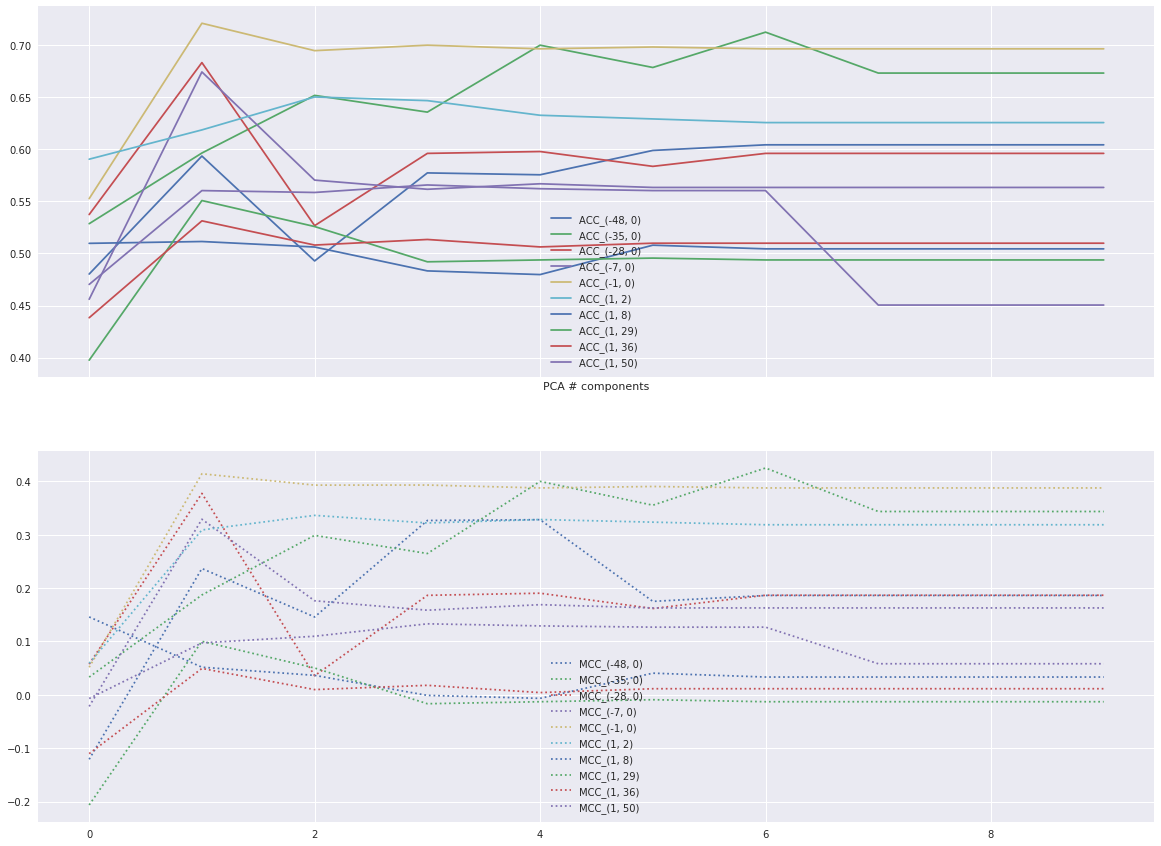

# comp:  5
trend:  -48   0
{(-48, 0): [0.6672661870503597], (-35, 0): [], (-28, 0): [], (-7, 0): [], (-1, 0): [], (1, 2): [], (1, 8): [], (1, 29): [], (1, 36): [], (1, 50): []}
trend:  -35   0
{(-48, 0): [0.6672661870503597], (-35, 0): [0.6857142857142857], (-28, 0): [], (-7, 0): [], (-1, 0): [], (1, 2): [], (1, 8): [], (1, 29): [], (1, 36): [], (1, 50): []}
trend:  -28   0
{(-48, 0): [0.6672661870503597], (-35, 0): [0.6857142857142857], (-28, 0): [0.5836298932384342], (-7, 0): [], (-1, 0): [], (1, 2): [], (1, 8): [], (1, 29): [], (1, 36): [], (1, 50): []}
trend:  -7   0
{(-48, 0): [0.6672661870503597], (-35, 0): [0.6857142857142857], (-28, 0): [0.5836298932384342], (-7, 0): [0.6602112676056338], (-1, 0): [], (1, 2): [], (1, 8): [], (1, 29): [], (1, 36): [], (1, 50): []}
trend:  -1   0
{(-48, 0): [0.6672661870503597], (-35, 0): [0.6857142857142857], (-28, 0): [0.5836298932384342], (-7, 0): [0.6602112676056338], (-1, 0): [0.6175438596491228], (1, 2): [], (1, 8): [], (1, 29): [], (1, 36)

{(-48, 0): [0.6672661870503597, 0.802158273381295, 0.737410071942446], (-35, 0): [0.6857142857142857, 0.6607142857142857, 0.675], (-28, 0): [0.5836298932384342, 0.6583629893238434, 0.693950177935943], (-7, 0): [0.6602112676056338, 0.75, 0.6672535211267606], (-1, 0): [0.6175438596491228, 0.6701754385964912], (1, 2): [0.6221441124780316, 0.5905096660808435], (1, 8): [0.6860670194003528, 0.6349206349206349], (1, 29): [0.46345811051693403, 0.5739750445632799], (1, 36): [0.5134168157423972, 0.5277280858676208], (1, 50): [0.572972972972973, 0.5405405405405406]}
trend:  -1   0
{(-48, 0): [0.6672661870503597, 0.802158273381295, 0.737410071942446], (-35, 0): [0.6857142857142857, 0.6607142857142857, 0.675], (-28, 0): [0.5836298932384342, 0.6583629893238434, 0.693950177935943], (-7, 0): [0.6602112676056338, 0.75, 0.6672535211267606], (-1, 0): [0.6175438596491228, 0.6701754385964912, 0.724561403508772], (1, 2): [0.6221441124780316, 0.5905096660808435], (1, 8): [0.6860670194003528, 0.63492063492063

{(-48, 0): [0.6672661870503597, 0.802158273381295, 0.737410071942446, 0.7679856115107914], (-35, 0): [0.6857142857142857, 0.6607142857142857, 0.675, 0.6392857142857142], (-28, 0): [0.5836298932384342, 0.6583629893238434, 0.693950177935943, 0.6690391459074733], (-7, 0): [0.6602112676056338, 0.75, 0.6672535211267606, 0.7200704225352113], (-1, 0): [0.6175438596491228, 0.6701754385964912, 0.724561403508772, 0.7421052631578947], (1, 2): [0.6221441124780316, 0.5905096660808435, 0.6572934973637962, 0.6432337434094904], (1, 8): [0.6860670194003528, 0.6349206349206349, 0.6754850088183422], (1, 29): [0.46345811051693403, 0.5739750445632799, 0.5311942959001783], (1, 36): [0.5134168157423972, 0.5277280858676208, 0.5366726296958855], (1, 50): [0.572972972972973, 0.5405405405405406, 0.47387387387387386]}
trend:  1   8
{(-48, 0): [0.6672661870503597, 0.802158273381295, 0.737410071942446, 0.7679856115107914], (-35, 0): [0.6857142857142857, 0.6607142857142857, 0.675, 0.6392857142857142], (-28, 0): [0.5

{(-48, 0): [0.6672661870503597, 0.802158273381295, 0.737410071942446, 0.7679856115107914, 0.7787769784172662], (-35, 0): [0.6857142857142857, 0.6607142857142857, 0.675, 0.6392857142857142, 0.6142857142857143], (-28, 0): [0.5836298932384342, 0.6583629893238434, 0.693950177935943, 0.6690391459074733, 0.6725978647686833], (-7, 0): [0.6602112676056338, 0.75, 0.6672535211267606, 0.7200704225352113, 0.7306338028169014], (-1, 0): [0.6175438596491228, 0.6701754385964912, 0.724561403508772, 0.7421052631578947, 0.7368421052631579], (1, 2): [0.6221441124780316, 0.5905096660808435, 0.6572934973637962, 0.6432337434094904, 0.6854130052724078], (1, 8): [0.6860670194003528, 0.6349206349206349, 0.6754850088183422, 0.5291005291005291], (1, 29): [0.46345811051693403, 0.5739750445632799, 0.5311942959001783, 0.5098039215686274], (1, 36): [0.5134168157423972, 0.5277280858676208, 0.5366726296958855, 0.5974955277280859], (1, 50): [0.572972972972973, 0.5405405405405406, 0.47387387387387386, 0.5171171171171172]

{(-48, 0): [0.6672661870503597, 0.802158273381295, 0.737410071942446, 0.7679856115107914, 0.7787769784172662, 0.7302158273381295], (-35, 0): [0.6857142857142857, 0.6607142857142857, 0.675, 0.6392857142857142, 0.6142857142857143, 0.6642857142857143], (-28, 0): [0.5836298932384342, 0.6583629893238434, 0.693950177935943, 0.6690391459074733, 0.6725978647686833, 0.6530249110320284], (-7, 0): [0.6602112676056338, 0.75, 0.6672535211267606, 0.7200704225352113, 0.7306338028169014, 0.7394366197183099], (-1, 0): [0.6175438596491228, 0.6701754385964912, 0.724561403508772, 0.7421052631578947, 0.7368421052631579], (1, 2): [0.6221441124780316, 0.5905096660808435, 0.6572934973637962, 0.6432337434094904, 0.6854130052724078], (1, 8): [0.6860670194003528, 0.6349206349206349, 0.6754850088183422, 0.5291005291005291, 0.5185185185185185], (1, 29): [0.46345811051693403, 0.5739750445632799, 0.5311942959001783, 0.5098039215686274, 0.46702317290552586], (1, 36): [0.5134168157423972, 0.5277280858676208, 0.5366726

{(-48, 0): [0.6672661870503597, 0.802158273381295, 0.737410071942446, 0.7679856115107914, 0.7787769784172662, 0.7302158273381295, 0.7913669064748201], (-35, 0): [0.6857142857142857, 0.6607142857142857, 0.675, 0.6392857142857142, 0.6142857142857143, 0.6642857142857143], (-28, 0): [0.5836298932384342, 0.6583629893238434, 0.693950177935943, 0.6690391459074733, 0.6725978647686833, 0.6530249110320284], (-7, 0): [0.6602112676056338, 0.75, 0.6672535211267606, 0.7200704225352113, 0.7306338028169014, 0.7394366197183099], (-1, 0): [0.6175438596491228, 0.6701754385964912, 0.724561403508772, 0.7421052631578947, 0.7368421052631579, 0.7631578947368421], (1, 2): [0.6221441124780316, 0.5905096660808435, 0.6572934973637962, 0.6432337434094904, 0.6854130052724078, 0.7275922671353251], (1, 8): [0.6860670194003528, 0.6349206349206349, 0.6754850088183422, 0.5291005291005291, 0.5185185185185185, 0.5855379188712522], (1, 29): [0.46345811051693403, 0.5739750445632799, 0.5311942959001783, 0.5098039215686274, 0

{(-48, 0): [0.6672661870503597, 0.802158273381295, 0.737410071942446, 0.7679856115107914, 0.7787769784172662, 0.7302158273381295, 0.7913669064748201], (-35, 0): [0.6857142857142857, 0.6607142857142857, 0.675, 0.6392857142857142, 0.6142857142857143, 0.6642857142857143, 0.6642857142857143], (-28, 0): [0.5836298932384342, 0.6583629893238434, 0.693950177935943, 0.6690391459074733, 0.6725978647686833, 0.6530249110320284, 0.6548042704626335], (-7, 0): [0.6602112676056338, 0.75, 0.6672535211267606, 0.7200704225352113, 0.7306338028169014, 0.7394366197183099, 0.7323943661971831], (-1, 0): [0.6175438596491228, 0.6701754385964912, 0.724561403508772, 0.7421052631578947, 0.7368421052631579, 0.7631578947368421, 0.7684210526315789], (1, 2): [0.6221441124780316, 0.5905096660808435, 0.6572934973637962, 0.6432337434094904, 0.6854130052724078, 0.7275922671353251, 0.70298769771529], (1, 8): [0.6860670194003528, 0.6349206349206349, 0.6754850088183422, 0.5291005291005291, 0.5185185185185185, 0.5855379188712

{(-48, 0): [0.6672661870503597, 0.802158273381295, 0.737410071942446, 0.7679856115107914, 0.7787769784172662, 0.7302158273381295, 0.7913669064748201, 0.7356115107913669], (-35, 0): [0.6857142857142857, 0.6607142857142857, 0.675, 0.6392857142857142, 0.6142857142857143, 0.6642857142857143, 0.6642857142857143, 0.6892857142857143], (-28, 0): [0.5836298932384342, 0.6583629893238434, 0.693950177935943, 0.6690391459074733, 0.6725978647686833, 0.6530249110320284, 0.6548042704626335, 0.6512455516014235], (-7, 0): [0.6602112676056338, 0.75, 0.6672535211267606, 0.7200704225352113, 0.7306338028169014, 0.7394366197183099, 0.7323943661971831], (-1, 0): [0.6175438596491228, 0.6701754385964912, 0.724561403508772, 0.7421052631578947, 0.7368421052631579, 0.7631578947368421, 0.7684210526315789], (1, 2): [0.6221441124780316, 0.5905096660808435, 0.6572934973637962, 0.6432337434094904, 0.6854130052724078, 0.7275922671353251, 0.70298769771529], (1, 8): [0.6860670194003528, 0.6349206349206349, 0.6754850088183

{(-48, 0): [0.6672661870503597, 0.802158273381295, 0.737410071942446, 0.7679856115107914, 0.7787769784172662, 0.7302158273381295, 0.7913669064748201, 0.7356115107913669], (-35, 0): [0.6857142857142857, 0.6607142857142857, 0.675, 0.6392857142857142, 0.6142857142857143, 0.6642857142857143, 0.6642857142857143, 0.6892857142857143], (-28, 0): [0.5836298932384342, 0.6583629893238434, 0.693950177935943, 0.6690391459074733, 0.6725978647686833, 0.6530249110320284, 0.6548042704626335, 0.6512455516014235], (-7, 0): [0.6602112676056338, 0.75, 0.6672535211267606, 0.7200704225352113, 0.7306338028169014, 0.7394366197183099, 0.7323943661971831, 0.7341549295774648], (-1, 0): [0.6175438596491228, 0.6701754385964912, 0.724561403508772, 0.7421052631578947, 0.7368421052631579, 0.7631578947368421, 0.7684210526315789, 0.7526315789473684], (1, 2): [0.6221441124780316, 0.5905096660808435, 0.6572934973637962, 0.6432337434094904, 0.6854130052724078, 0.7275922671353251, 0.70298769771529, 0.70298769771529], (1, 8)

{(-48, 0): [0.6672661870503597, 0.802158273381295, 0.737410071942446, 0.7679856115107914, 0.7787769784172662, 0.7302158273381295, 0.7913669064748201, 0.7356115107913669, 0.7284172661870504], (-35, 0): [0.6857142857142857, 0.6607142857142857, 0.675, 0.6392857142857142, 0.6142857142857143, 0.6642857142857143, 0.6642857142857143, 0.6892857142857143, 0.7178571428571429], (-28, 0): [0.5836298932384342, 0.6583629893238434, 0.693950177935943, 0.6690391459074733, 0.6725978647686833, 0.6530249110320284, 0.6548042704626335, 0.6512455516014235, 0.6565836298932385], (-7, 0): [0.6602112676056338, 0.75, 0.6672535211267606, 0.7200704225352113, 0.7306338028169014, 0.7394366197183099, 0.7323943661971831, 0.7341549295774648, 0.7200704225352113], (-1, 0): [0.6175438596491228, 0.6701754385964912, 0.724561403508772, 0.7421052631578947, 0.7368421052631579, 0.7631578947368421, 0.7684210526315789, 0.7526315789473684], (1, 2): [0.6221441124780316, 0.5905096660808435, 0.6572934973637962, 0.6432337434094904, 0.6

{(-48, 0): [0.6672661870503597, 0.802158273381295, 0.737410071942446, 0.7679856115107914, 0.7787769784172662, 0.7302158273381295, 0.7913669064748201, 0.7356115107913669, 0.7284172661870504], (-35, 0): [0.6857142857142857, 0.6607142857142857, 0.675, 0.6392857142857142, 0.6142857142857143, 0.6642857142857143, 0.6642857142857143, 0.6892857142857143, 0.7178571428571429], (-28, 0): [0.5836298932384342, 0.6583629893238434, 0.693950177935943, 0.6690391459074733, 0.6725978647686833, 0.6530249110320284, 0.6548042704626335, 0.6512455516014235, 0.6565836298932385], (-7, 0): [0.6602112676056338, 0.75, 0.6672535211267606, 0.7200704225352113, 0.7306338028169014, 0.7394366197183099, 0.7323943661971831, 0.7341549295774648, 0.7200704225352113], (-1, 0): [0.6175438596491228, 0.6701754385964912, 0.724561403508772, 0.7421052631578947, 0.7368421052631579, 0.7631578947368421, 0.7684210526315789, 0.7526315789473684, 0.775438596491228], (1, 2): [0.6221441124780316, 0.5905096660808435, 0.6572934973637962, 0.64

{(-48, 0): [0.6672661870503597, 0.802158273381295, 0.737410071942446, 0.7679856115107914, 0.7787769784172662, 0.7302158273381295, 0.7913669064748201, 0.7356115107913669, 0.7284172661870504, 0.7338129496402878], (-35, 0): [0.6857142857142857, 0.6607142857142857, 0.675, 0.6392857142857142, 0.6142857142857143, 0.6642857142857143, 0.6642857142857143, 0.6892857142857143, 0.7178571428571429, 0.7232142857142857], (-28, 0): [0.5836298932384342, 0.6583629893238434, 0.693950177935943, 0.6690391459074733, 0.6725978647686833, 0.6530249110320284, 0.6548042704626335, 0.6512455516014235, 0.6565836298932385, 0.6548042704626335], (-7, 0): [0.6602112676056338, 0.75, 0.6672535211267606, 0.7200704225352113, 0.7306338028169014, 0.7394366197183099, 0.7323943661971831, 0.7341549295774648, 0.7200704225352113, 0.7165492957746479], (-1, 0): [0.6175438596491228, 0.6701754385964912, 0.724561403508772, 0.7421052631578947, 0.7368421052631579, 0.7631578947368421, 0.7684210526315789, 0.7526315789473684, 0.77543859649

{(-48, 0): [0.6672661870503597, 0.802158273381295, 0.737410071942446, 0.7679856115107914, 0.7787769784172662, 0.7302158273381295, 0.7913669064748201, 0.7356115107913669, 0.7284172661870504, 0.7338129496402878], (-35, 0): [0.6857142857142857, 0.6607142857142857, 0.675, 0.6392857142857142, 0.6142857142857143, 0.6642857142857143, 0.6642857142857143, 0.6892857142857143, 0.7178571428571429, 0.7232142857142857], (-28, 0): [0.5836298932384342, 0.6583629893238434, 0.693950177935943, 0.6690391459074733, 0.6725978647686833, 0.6530249110320284, 0.6548042704626335, 0.6512455516014235, 0.6565836298932385, 0.6548042704626335], (-7, 0): [0.6602112676056338, 0.75, 0.6672535211267606, 0.7200704225352113, 0.7306338028169014, 0.7394366197183099, 0.7323943661971831, 0.7341549295774648, 0.7200704225352113, 0.7165492957746479], (-1, 0): [0.6175438596491228, 0.6701754385964912, 0.724561403508772, 0.7421052631578947, 0.7368421052631579, 0.7631578947368421, 0.7684210526315789, 0.7526315789473684, 0.77543859649

<Figure size 432x288 with 0 Axes>

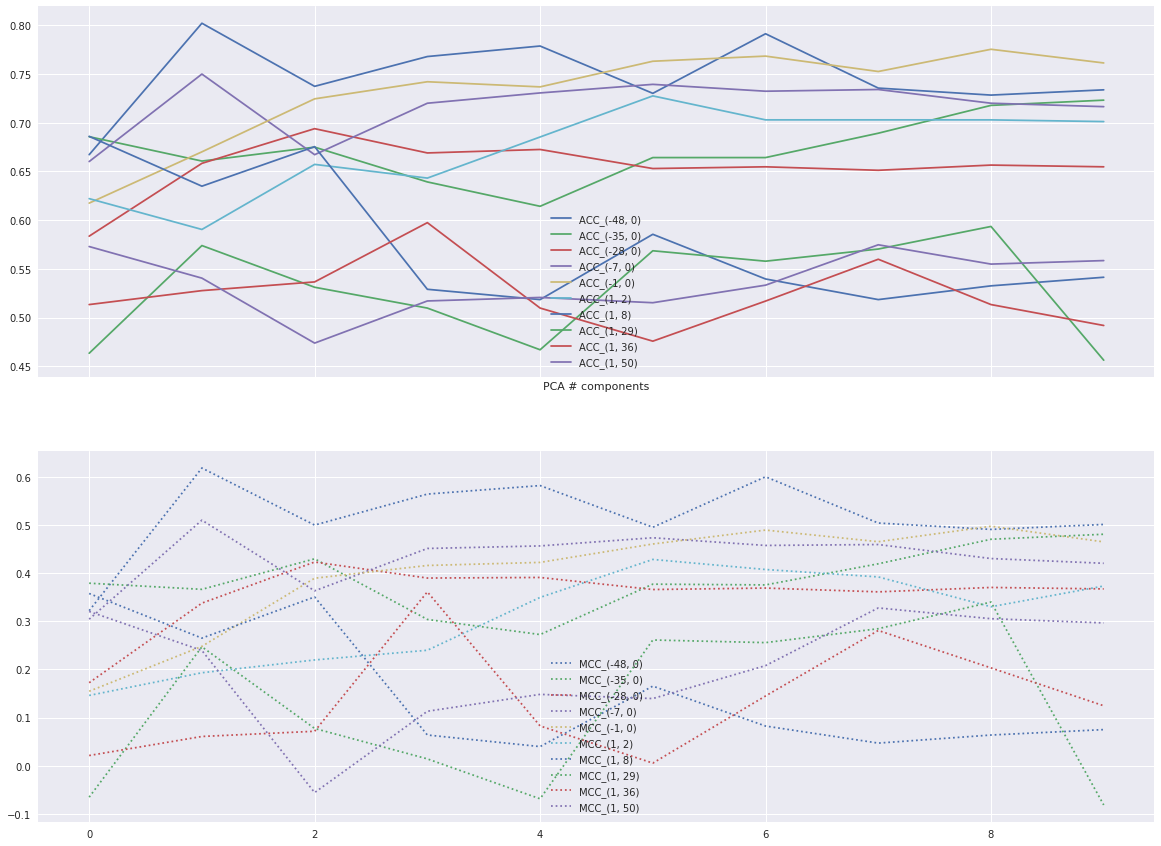

In [3]:
# ========== simple SVM with PCA =================
from sklearn.decomposition import PCA
PCA_steps = 10

#NORMALIZATION:
min_max_scaler = preprocessing.MinMaxScaler()
X_google = np.nan_to_num(np.asarray(X_google, dtype=float))
X_google = np.asarray(min_max_scaler.fit_transform(X_google))

X_dict = np.nan_to_num(np.asarray(X_dict, dtype=float))
X_dict = np.asarray(min_max_scaler.fit_transform(X_dict))

for (X,ds) in [(X_google,'Google'),(X_dict,'Dict')]:
    MCCs = {(init, finish) : list() for (init, finish) in TREND_WINDOWs}
    ACCs = {(init, finish) : list() for (init, finish) in TREND_WINDOWs}
    for n_comp in np.linspace(5, X.shape[1], PCA_steps, endpoint=True, dtype = int):
        print('# comp: ',n_comp)
        X_PCA = PCA(n_components=n_comp).fit_transform(X)
        
        for (init, finish) in TREND_WINDOWs:
            print('trend: ',init,' ',finish)
            
            #CONSTRUCT LABELS
            x = list()
            y = list()

            means = list()
            runningMean = 0
            for i in range(len(price['volume'])):
                runningMean +=price['volume'][i]
                means.append(runningMean/(i+1))

            for i in range(abs(init),len(price)-finish):
                s=np.sign(price['volume'][i+init:i+finish].mean() - means[i])
                if(s==-1):
                    y.append(0)
                else:
                    y.append(1)
                x.append(X_PCA[i])

            y = np.array(y)
            x = np.array(x)
            
           #DATASET DIVISION:
            train=0.7
            nt=math.ceil(len(x)*train)
            x_tv = x[:nt]
            y_tv = y[:nt]
            x_test = x[nt:]
            y_test = y[nt:]

            best_mcc = -float(np.inf)
            best_c = 0
            best_g = 0
            for c in np.logspace(-3,4,10):
                for g in np.logspace(-3,4,10):
                    trainpoint=math.floor(len(x_tv)*0.50)
                    dimval=math.floor(trainpoint*0.25)
                    endval=trainpoint+dimval
                    #Cross validation
                    cvMCC = 0
                    for i in range(0,4):
                        x_train=x_tv[0:trainpoint]
                        y_train=y_tv[0:trainpoint]
                        x_val=x_tv[trainpoint:endval]
                        y_val=y_tv[trainpoint:endval]
                        trainpoint=trainpoint+dimval
                        endval=endval+dimval
                        svm_model = svm.SVC(kernel='rbf', C=c, gamma=g)
                        svm_model.fit(x_train,y_train)
                        y_pred = svm_model.predict(x_val)
                        confmatrix = confusion_matrix(y_val, y_pred)
                        tn, fp, fn, tp = confmatrix.ravel()
                        denom = (tp+fp)*(tp+fn)*(tn+fp)*(tn+fn)
                        mcc = 0 if denom== 0 else (tp*tn -fp*fn)/sqrt(denom)
                        cvMCC += mcc/6

                    if(cvMCC > best_mcc):
                        best_mcc = cvMCC
                        best_c = c
                        best_g = g
                        

            svm_model = svm.SVC(kernel='rbf', C=best_c, gamma=best_g)
            svm_model.fit(x_tv,y_tv)
            acc = svm_model.score(x_test,y_test)
            y_pred = svm_model.predict(x_test)
            confmatrix = confusion_matrix(y_test, y_pred)
            tn, fp, fn, tp = confmatrix.ravel()
            denom = (tp+fp)*(tp+fn)*(tn+fp)*(tn+fn)
            mcc = 0 if denom== 0 else (tp*tn -fp*fn)/sqrt(denom)
            ACCs[(init, finish)].append(acc)
            MCCs[(init, finish)].append(mcc)
            print(ACCs)
            
    print(ds)
    plt.figure()
    f, axarr = plt.subplots(2, sharex=True, figsize=(20,15))
    for (init, finish) in MCCs.keys():
        axarr[1].plot(MCCs[(init, finish)], label='MCC_('+str(init)+', '+str(finish)+')')
        axarr[0].plot(ACCs[(init, finish)], label='ACC_('+str(init)+', '+str(finish)+')')
    axarr[0].set(xlabel='PCA # components')
    axarr[1].legend()
    axarr[0].legend()
    f.savefig('volumePredictions/onlyNews/PCA_'+str(ds)+'.jpg')
    plt.show()


